# Code gists for ECML21 submission 396

## TRAMESINO: Traffic Memory System for Intelligent Optimization of Road Traffic Control

In [18]:
%matplotlib inline
# useful libs
import matplotlib.pyplot as plt
import math
import importlib
import numpy as np
import string
from scipy.fftpack import fftn, ifftn

### Define operations in the Holographic Reduced Representation used in TRAMESINO

In [19]:

def memory_power(memory_vector, memory_power):
    return ifftn(fftn(memory_vector, shape=memory_vector.shape)**memory_power).real


def memory_rotate(memory_vectors, rotateby=1):
    return np.roll(memory_vectors, rotateby, axis=0)


def memory_involution(memory_vector):
    if len(memory_vector.shape) == 1:
        return np.append(memory_vector[0], memory_vector[1:][::-1])
    else:
        return np.concatenate(([memory_vector[0]], memory_vector[1:][::-1]), axis=0)


def fftconvolve(memory_vectors1, memory_vectors2):
    return ifftn(fftn(memory_vectors1, shape=memory_vectors1.shape)
                 * fftn(memory_vectors2, shape=memory_vectors2.shape)).real


def fftcorrelate(memory_vectors1, memory_vectors2):
    return fftconvolve(memory_involution(memory_vectors1), memory_vectors2)


def memory_bind(memory_vectors1, memory_vectors2):
    if memory_vectors1.shape == memory_vectors2.shape:
        return fftconvolve(memory_vectors1, memory_vectors2)
    elif len(memory_vectors1.shape) == 1:
        return fftconvolve(memory_vectors1[np.newaxis].reshape(memory_vectors2.shape), memory_vectors2)
    elif len(memory_vectors2.shape) == 1:
        return fftconvolve(memory_vectors1, memory_vectors2[np.newaxis].reshape(memory_vectors1.shape))
    else:
        raise Exception("Dimensions of arrays must agree or one of them should be a vector")


def memory_unbind(memory_vectors1, memory_vectors2):
    if memory_vectors1.shape == memory_vectors2.shape:
        return fftcorrelate(memory_vectors1, memory_vectors2)
    elif len(memory_vectors1.shape) == 1:
        return fftcorrelate(memory_vectors1[np.newaxis].reshape(memory_vectors2.shape), memory_vectors2)
    elif len(memory_vectors2.shape) == 1:
        return fftcorrelate(memory_vectors1, memory_vectors2[np.newaxis].reshape(memory_vectors1.shape))
    else:
        raise Exception("Dimensions of arrays must agree or one of them should be a vector")


def memory_bundle(memory_vectors, norm="frobenius", optype="unrestricted", kappa=3, **kwargs):
    if len(memory_vectors[0].shape) == 1:
        base = memory_vectors[0]
    else:
        base = np.sum(memory_vectors[0], axis=1)
        if norm == "frobenius":
            base = np.divide(np.expand_dims(base, axis=1), np.linalg.norm(base, axis=0))
        elif norm == "scaling":
            base = np.expand_dims(base, axis=1) / math.sqrt(memory_vectors[0].shape[1])
        else:
            raise Exception("The normalization method is not defined")

    # Regular addition
    if optype == "unrestricted":
        return base
    # Clipping function
    elif optype == "clipping":
        base[base > kappa] = kappa
        base[base < -kappa] = -kappa
        return base
    else:
        raise Exception("The type is not defined")


def memory_map(concepts, N=1000):
    memory = np.random.normal(loc = 0.0, scale = math.sqrt(1/N), size =(N, len(concepts)))
    return [memory,concepts]

def memory_similarity(memory_vectors1, memory_vectors2, stype="dot"):
    dp = np.dot(np.transpose(memory_vectors1), memory_vectors2)
    if stype == "dot":
        return dp
    elif stype == "cosine":
        norms = (np.dot(np.expand_dims(np.linalg.norm(memory_vectors1, axis=0), axis=1),
                        np.expand_dims(np.linalg.norm(memory_vectors2, axis=0), axis=0)))
        dp.astype(float)
        return np.divide(dp, norms)
    else:
        raise Exception("The type is not defined")


def memory_get_item(item_mem, concepts):
    concepts = concepts.tolist()
    memory_vectors = np.zeros((item_mem[0].shape[0], len(concepts)), dtype=float)
    for i in range(len(concepts)):
        con = concepts[i]
        ind = item_mem[1].tolist().index(con)
        if ind != -1:
            memory_vectors[:, i] = item_mem[0][:, ind]
        else:
            raise Exception("The concept is not present in the item memory")
    return [memory_vectors, concepts]


def memory_recall(itemmem, query, searchtype="nearest", simtype="dot"):
    scores = memory_similarity(itemmem[0], query, stype=simtype)

    if searchtype == "nearest":
        ind = np.argmax(scores)
        return [np.expand_dims(itemmem[0][:, ind], axis=1), itemmem[1][ind]]
    else:
        raise Exception("The specified search type is not defined")
        
        
def memory_sequence(itemmem, concepts, cue=None, rerptype="bundling", bundlingtype="unrestricted", kappa=3):
    hrrvectors=memory_get_item(itemmem, concepts)

    # create composite hrr vector
    if rerptype == "bundling":  # if the representation is bundling based
        # prepare rotated hrr vectors
        for i in range(1, len(concepts)):
            hrrvectors[0][:, i] = memory_rotate(hrrvectors[0][:, i], rotateby=i)
        return memory_bundle(hrrvectors, optype=bundlingtype, kappa=kappa)  # perform bundling of the desired hrr vectors
    elif rerptype == "binding":  # if the representation is binding based
        hrrseq = hrrvectors[0][:, 0]
        for i in range(1, len(concepts)):
            hrrvectors[0][:, i] = memory_rotate(hrrvectors[0][:, i], rotateby=i)
            hrrseq = memory_bind(hrrseq, hrrvectors[0][:, i])
        return np.expand_dims(hrrseq, axis=1)  # to keep (N,1) shape
    elif rerptype == "trajectory":
        if cue is not None:
            for i in range(1, len(concepts)):
                hrrvectors[0][:, i] = memory_bind(memory_power(cue, i), hrrvectors[0][:, i])
            return memory_bundle(hrrvectors, optype=bundlingtype, kappa=kappa)
        else:
            raise Exception("Parameter cue must be a unitary vector")
    elif rerptype == "chaining":
        hrrseq = hrrvectors[0][:, 0]
        for i in range(1, len(concepts)):
            hrrvectors[0][:, i] = memory_bind(hrrvectors[0][:, i], hrrseq)
            hrrseq = hrrvectors[0][:, i]
        return memory_bundle(hrrvectors, optype=bundlingtype, kappa=kappa)
    else:
        raise Exception("HRR type %s does not support %s-based representations." % (vsatype, rerptype))

### Traffic data sample

In [20]:
import pandas as pd
# data is in the format
# tls_id	green_time	car_count	phase_idx
traffic_data = pd.read_csv('./tramesino_sample_data.csv')
traffic_data = traffic_data.drop_duplicates()
traffic_data

,tls_id,phase_idx,green_time,car_count
0,788876,2,15,11
1,788876,3,12,0
2,763080,2,20,6
3,763080,3,15,4
4,761368,2,11,5
...,...,...,...,...
1150,761368,3,12,6
1151,761368,4,15,4
1152,761419,2,18,22
1153,761419,3,12,13


### Traffic data preparation

In [21]:
# recursive dataframe to nested dict
def recur_dictify(frame):
    if len(frame.columns) == 2:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    grouped = frame.groupby(frame.columns[0])
    d = {k: recur_dictify(g.iloc[:,1:]) for k,g in grouped}
    return d
prep_data = recur_dictify(traffic_data)

In [22]:
# recursive dataframe to nested dict
def recur_dictify(frame):
    if len(frame.columns) == 2:
        if frame.values.size == 1: return frame.values[0][0]
        return frame.values.squeeze()
    grouped = frame.groupby(frame.columns[0])
    d = {k: recur_dictify(g.iloc[:,1:]) for k,g in grouped}
    return d
prep_data = recur_dictify(traffic_data)

### Build memories of traffic data

In [23]:
itemMemory = {}
N=128

# loop for all tlsid and phaseid configurations
for tlsid in traffic_data.tls_id.unique():
    for phid in traffic_data.phase_idx.unique():
        try:
            cur_entry = prep_data[tlsid][phid].astype(list)
        except KeyError:
            pass
        if tlsid not in itemMemory:
            itemMemory[tlsid] = {}
        if phid not in itemMemory[tlsid]:
            itemMemory[tlsid][phid] = []
        itemMemory[tlsid][phid] = memory_map(cur_entry, N)   

### Test traffic data memory recall

In [24]:
# given a new traffic car count 
new_item = memory_map([[11,]], N) 

In [25]:
# recall the closest memory
memory_seq_bundling=memory_sequence(itemMemory[tlsid][phid], itemMemory[tlsid][phid][1], cue=np.array(new_item[0]).ravel(), rerptype="trajectory", bundlingtype="unrestricted")
mem_rec = memory_recall(itemMemory[tlsid][phid], memory_seq_bundling, searchtype="nearest", simtype="cosine")

In [26]:
# recall from the memory the green time
green_time = mem_rec[1][0]
green_time

13

### Analysis

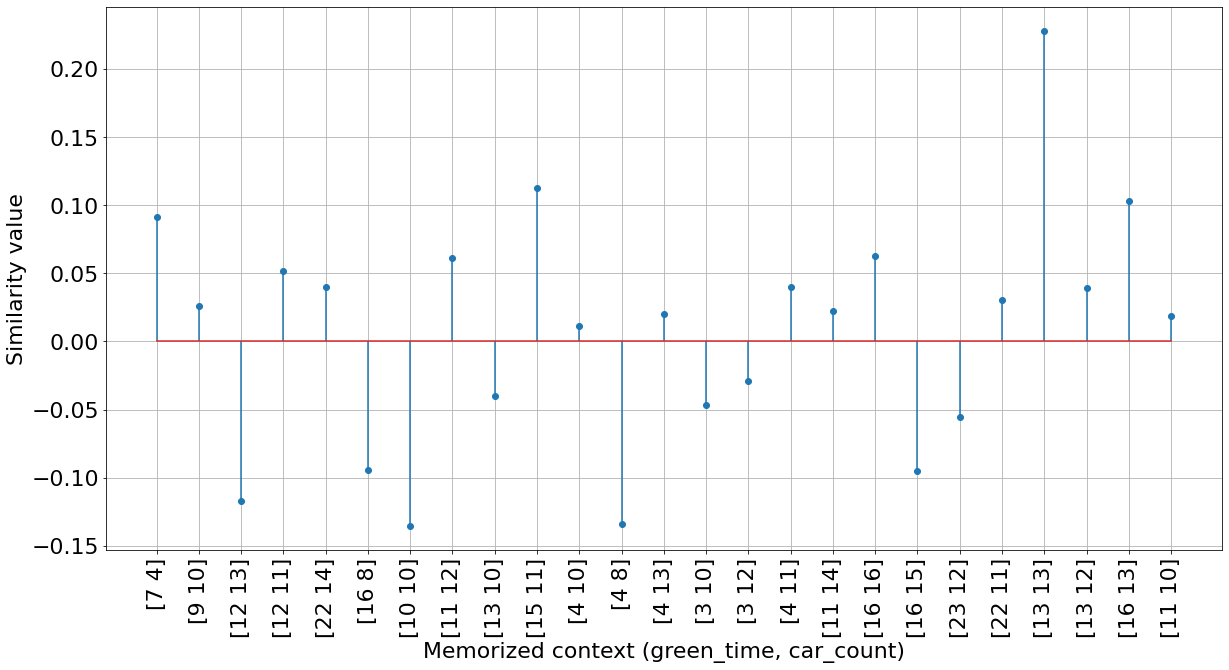

In [27]:
# plot memory similarity
similarity = memory_similarity(itemMemory[tlsid][phid][0], memory_seq_bundling, stype="dot")
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.stem(similarity, use_line_collection=True)
concepts = itemMemory[tlsid][phid][1]
plt.xticks([i for i in range(len(concepts))], map(str,concepts), rotation='vertical')  
plt.ylabel('Similarity value')
plt.xlabel('Memorized context (green_time, car_count)')
plt.grid()
plt.show()

### Encoding anlaysis

In [28]:
itemMemory[tlsid][phid][0]

array([[-0.00174567, -0.06336246,  0.14350951, ..., -0.06983726,
        -0.06975556, -0.011417  ],
       [-0.10687172,  0.10063214,  0.00207203, ..., -0.0166041 ,
        -0.16463178,  0.03957271],
       [-0.01765501, -0.01724981, -0.07432961, ...,  0.00540009,
         0.02730208,  0.01247629],
       ...,
       [-0.05311193, -0.09188605, -0.05736209, ..., -0.01992476,
         0.03274925,  0.06847214],
       [-0.01686914,  0.02748312, -0.01588228, ...,  0.12475726,
        -0.00553937, -0.05733193],
       [-0.13201825,  0.05954332, -0.05874845, ..., -0.09893904,
         0.13769523, -0.13144713]])

In [29]:
print("Size of the item memory:",  itemMemory[tlsid][phid][0].shape)
print("Content of the item memory:")
print(itemMemory[tlsid][phid][0])
print("Content of the whole association memory:")
print(itemMemory)     

Size of the item memory: (128, 25)
Content of the item memory:
[[-0.00174567 -0.06336246  0.14350951 ... -0.06983726 -0.06975556
  -0.011417  ]
 [-0.10687172  0.10063214  0.00207203 ... -0.0166041  -0.16463178
   0.03957271]
 [-0.01765501 -0.01724981 -0.07432961 ...  0.00540009  0.02730208
   0.01247629]
 ...
 [-0.05311193 -0.09188605 -0.05736209 ... -0.01992476  0.03274925
   0.06847214]
 [-0.01686914  0.02748312 -0.01588228 ...  0.12475726 -0.00553937
  -0.05733193]
 [-0.13201825  0.05954332 -0.05874845 ... -0.09893904  0.13769523
  -0.13144713]]
Content of the whole association memory:
{788876: {2: [array([[ 0.04286697,  0.10255222,  0.0249432 , ...,  0.09950484,
         0.10462559,  0.10262851],
       [-0.03951798,  0.02948231,  0.11952185, ...,  0.00074248,
         0.13925217, -0.00276098],
       [ 0.00040309,  0.02673589, -0.10274869, ...,  0.05162552,
         0.08043723, -0.0805885 ],
       ...,
       [ 0.09330529,  0.03317905, -0.15705207, ...,  0.06439794,
        -0.00